# Parameters

In [1]:
n_colors = 1
n_examples_per_class = 1000   # if 0, there is no data augmentation
rescaling = False
global_normalisation = False
local_normalisation = True
epochs = 10
batch_size = 128
rate = 0.001

# Import data

In [2]:
import pickle

training_file = '../../data/train.p'
testing_file = '../../data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

# Train / validation split

The validation set is extracted from the test set rather than the training set.  
Indeed, examples in the training set are highly correlated (sequences of 30 images of the same traffic sign) and one would have to decorrelate them in order to create a correct validation set.  

Calculate the track_id per class

In [3]:
import numpy as np

n_images_per_track = 30

track_id = []
for i, _ in enumerate(y_train):
    if i < 33749:   # because this one is missing
        track_id.append(i // n_images_per_track)
    else:
        track_id.append((i+1) // n_images_per_track)
track_id = np.array(track_id)

Then splits the dataset between train and test while not splitting tracks

In [4]:
valid_size = 0.15
valid_indexes = []

for class_number in np.unique(y_train):
    class_tracks = np.unique(track_id[np.where(y_train == class_number)[0]])
    class_valid_tracks = np.random.choice(class_tracks, int(class_tracks.shape[0] * valid_size))
    class_valid_indexes = np.where(np.in1d(track_id, class_valid_tracks))[0]
    valid_indexes += class_valid_indexes.tolist()

valid_indexes = np.array(valid_indexes)
train_indexes = np.array([x for x, _ in enumerate(y_train) if x not in valid_indexes.tolist()])

X_valid = X_train[valid_indexes]
y_valid = y_train[valid_indexes]
X_train = X_train[train_indexes]
y_train = y_train[train_indexes]

# Data augmentation

New training images are created using scaling, rotation and pixel shifting

In [5]:
from PIL import Image

def shift(t, x, y):
    a = t.copy()
    if x > 0:
        a[x:, :, :] = a[:-x, :, :]
        a[:x, :, :] = 0
    elif x < 0:
        a[:x, :, :] = a[-x:, :, :]
        a[x:, :, :] = 0
    if y > 0:
        a[:, y:, :] = a[:, :-y, :]
        a[:, :y, :] = 0
    elif y < 0:
        a[:, :y, :] = a[:, -y:, :]
        a[:, y:, :] = 0
    return a

def rotate(t, a):
    return np.array(Image.fromarray(t).rotate(a, expand=False)).copy()

def scale(t, f):
    a = t.copy()
    new_size = int(f*32)
    if new_size != 32:
        size = new_size, new_size
        im = Image.fromarray(a).resize(size)
        a = np.array(im)
        if new_size > 32:
            a = a[int(a.shape[0]/2)-16:int(a.shape[0]/2)+16, int(a.shape[0]/2)-16:int(a.shape[0]/2)+16, :]
        else:
            temp = np.zeros((32, 32, 3))
            decay = int((32-a.shape[0])/2)
            temp[decay:decay+a.shape[0],decay:decay+a.shape[0],:] = a
            a = temp
    return a

#### Dataset rebalancing (using augmentated data)

In [6]:
n_classes = np.unique(y_train).shape[0]

for c in np.unique(y_train):
    indexes = np.where(y_train == c)[0]
    n_new_examples = n_examples_per_class-indexes.shape[0]
    if n_new_examples > 0:
        new_samples_indexes = np.random.choice(indexes, n_new_examples, replace=True)
        X_train_new = X_train[new_samples_indexes]
        y_train_new = y_train[new_samples_indexes]
        for i in range(n_new_examples):
            x_shift = np.random.randint(low=-2, high=+2)
            y_shift = np.random.randint(low=-2, high=+2)
            rotation_angle = np.random.randint(low=-10, high=+10)
            scale_factor = np.random.uniform(low=.9, high=1.1)
            X_train_new[i,:,:,:] = scale(X_train_new[i,:,:,:], scale_factor)
            X_train_new[i,:,:,:] = rotate(X_train_new[i,:,:,:], rotation_angle)
            X_train_new[i,:,:,:] = shift(X_train_new[i,:,:,:], x_shift, y_shift)
        X_train = np.append(X_train, X_train_new, axis=0)
        y_train = np.append(y_train, y_train_new, axis=0)

# Preprocessing

#### Convert to grayscale 

In [7]:
if n_colors == 1:
    r = 0.299
    g = 0.587
    b = 0.114
    X_train = X_train[:,:,:,0]*r + X_train[:,:,:,1]*g + X_train[:,:,:,2]*b
    X_test = X_test[:,:,:,0]*r + X_test[:,:,:,1]*g + X_test[:,:,:,2]*b
    X_valid = X_valid[:,:,:,0]*r + X_valid[:,:,:,1]*g + X_valid[:,:,:,2]*b
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
    X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], X_valid.shape[2], 1))

#### Rescaling values to [0,1]

In [9]:
if rescaling:
    max_value = X_train.max()
    X_train = (X_train-max_value)/max_value
    X_test = (X_test-max_value)/max_value
    X_valid = (X_valid-max_value)/max_value

#### Normalisation

In [10]:
if global_normalisation or local_normalisation:
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    X_valid = X_valid.astype(np.float32)

# global normalisation
if global_normalisation:
    global_mean_train = np.repeat(X_train.mean(axis=0).mean(axis=0).mean(axis=0).reshape((1, 3)), X_train.shape[0], axis=0)
    global_mean_test = np.repeat(X_test.mean(axis=0).mean(axis=0).mean(axis=0).reshape((1, 3)), X_test.shape[0], axis=0)
    global_mean_valid = np.repeat(X_valid.mean(axis=0).mean(axis=0).mean(axis=0).reshape((1, 3)), X_valid.shape[0], axis=0)
    X_train -= np.swapaxes(np.swapaxes(np.tile(global_mean_train, (32, 32, 1, 1)), 2, 1), 1, 0)
    X_test -= np.swapaxes(np.swapaxes(np.tile(global_mean_test, (32, 32, 1, 1)), 2, 1), 1, 0)
    X_valid -= np.swapaxes(np.swapaxes(np.tile(global_mean_valid, (32, 32, 1, 1)), 2, 1), 1, 0)

# local normalisation
if local_normalisation:
    for i in range(X_train.shape[0]):
        X_train[i] = (X_train[i] - X_train[i].mean()) / X_train[i].std()
    for i in range(X_test.shape[0]):
        X_test[i] = (X_test[i] - X_test[i].mean()) / X_test[i].std()
    for i in range(X_valid.shape[0]):
        X_valid[i] = (X_valid[i] - X_valid[i].mean()) / X_valid[i].std()

#### Shuffling

In [11]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)

# LeNet 5 implementation

#### Placeholders

In [12]:
import tensorflow as tf

x = tf.placeholder(tf.float32, (None, 32, 32, n_colors))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32)

#### LeNet-5

In [13]:
from tensorflow.contrib.layers import flatten

def LeNet(x, keep_prob):
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, n_colors, 6), mean = mu, stddev = sigma), name='conv1_W')
    conv1_b = tf.Variable(tf.zeros(6), name='conv1_b')
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma), name='conv2_W')
    conv2_b = tf.Variable(tf.zeros(16), name='conv2_b')
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma), name='fc1_W')
    fc1_b = tf.Variable(tf.zeros(120), name='fc1_b')
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma), name='fc2_W')
    fc2_b  = tf.Variable(tf.zeros(84), name='fc2_b')
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma), name='fc3_W')
    fc3_b  = tf.Variable(tf.zeros(43), name='fc3_b')
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

#### Training pipeline

In [14]:
logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

#### Model evaluation

In [15]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

#### Model training

In [16]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(epochs):
        for offset in range(0, num_examples, batch_size):
            end = offset + batch_size
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        print("EPOCH {} ...".format(i+1))
        train_accuracy = evaluate(X_train, y_train)
        print("Train Accuracy = {:.3f}".format(train_accuracy))
        validation_accuracy = evaluate(X_valid, y_valid)
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Train Accuracy = 0.792
Validation Accuracy = 0.788



KeyboardInterrupt: 

#### Model testing

In [17]:
saver = tf.train.Saver()

# Launch the graph
with tf.Session() as sess:
    saver.restore(sess, './lenet')
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.925


#### Worst mistakes

In [18]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, './lenet')
    mistakes = sess.run(cross_entropy, feed_dict={x: X_test, y: y_test, keep_prob: 1.0})

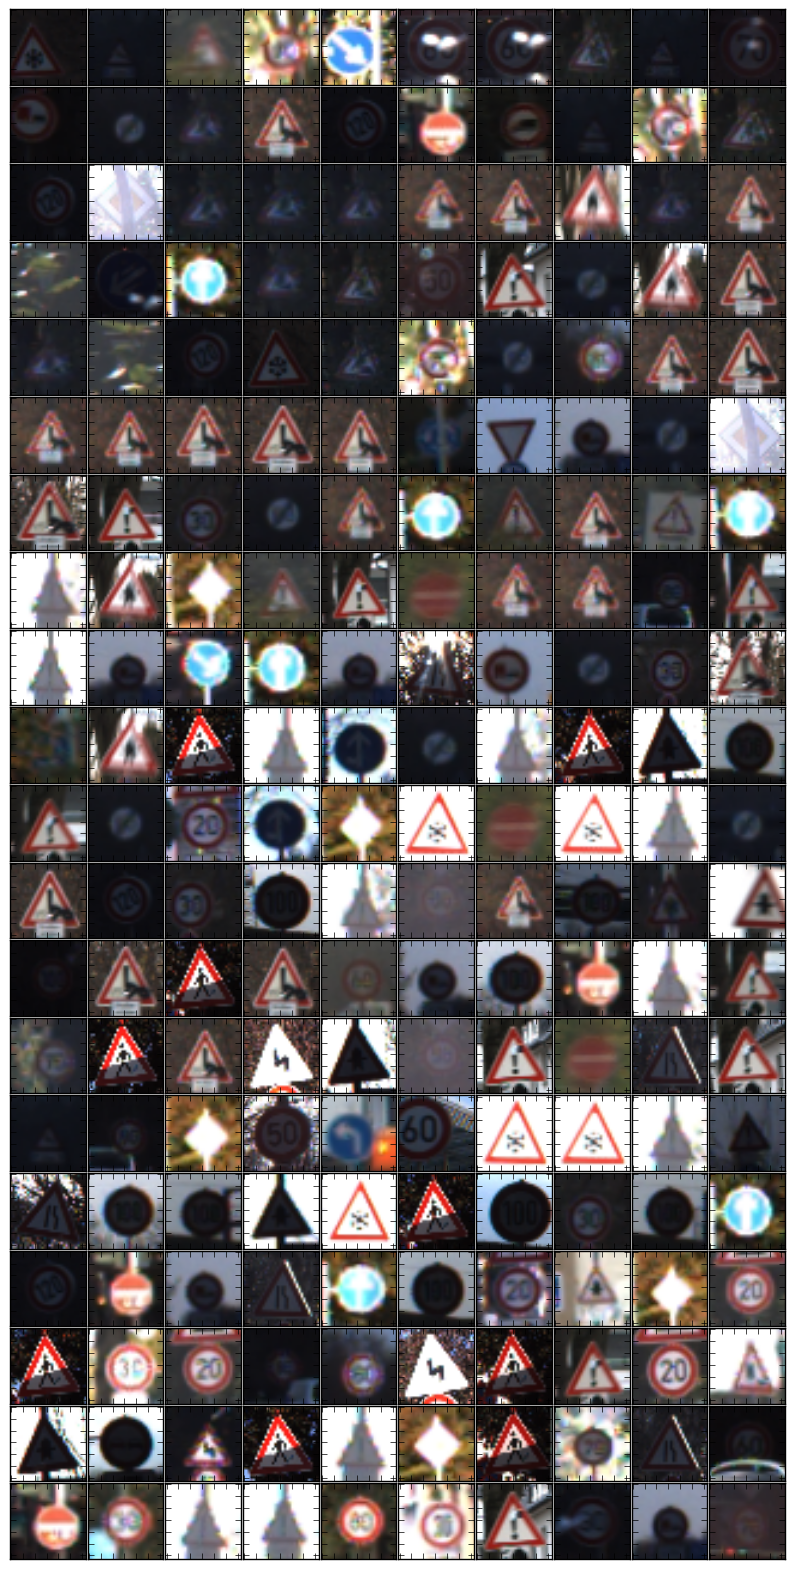

In [19]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

n_row = 20
n_col = 10

plt.figure(figsize = (n_col,n_row))
gs1 = gridspec.GridSpec(n_row, n_col)
gs1.update(wspace=0.025, hspace=0.025) 

for i, example_index in enumerate(np.argsort(-mistakes)[:n_row * n_col]):
    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    plt.imshow(test['features'][example_index])

plt.show()